# Bước 6: Phân cụm khách hàng từ Luật kết hợp (Association Rules → Clustering)

Notebook này lấy **kết quả luật kết hợp** (Apriori/FP-Growth) và biến chúng thành **đặc trưng** để phân cụm khách hàng bằng K-Means.

## Ý tưởng cốt lõi
- Mỗi luật có dạng: **Antecedent → Consequent**
- Với mỗi khách hàng, ta kiểm tra: khách đó đã từng mua **đủ antecedents** của luật hay chưa.
- Mỗi luật trở thành một feature (0/1 hoặc có trọng số theo lift/confidence).
- (Tuỳ chọn) Ghép thêm **RFM** để phân cụm ổn định hơn.


## Parameters
Gán tham số để chạy bằng papermill.


In [1]:
# PARAMETERS (for papermill)

# Input
CLEANED_DATA_PATH = "data/processed/cleaned_uk_data.csv"
RULES_INPUT_PATH = "data/processed/rules_apriori_filtered.csv"  # hoặc rules_fpgrowth_filtered.csv

# Feature engineering
TOP_K_RULES = 200
SORT_RULES_BY = "lift"      # lift | confidence | support
WEIGHTING = "lift"          # none | lift | confidence | support | lift_x_conf
MIN_ANTECEDENT_LEN = 1
USE_RFM = True
RFM_SCALE = True
RULE_SCALE = False

# Clustering
K_MIN = 2
K_MAX = 10
N_CLUSTERS = None            # None => chọn theo silhouette, hoặc đặt số cụ thể (vd 5)
RANDOM_STATE = 42

# Output
OUTPUT_CLUSTER_PATH = "data/processed/customer_clusters_from_rules.csv"

# Visual
PROJECTION_METHOD = "pca"   # pca | svd
PLOT_2D = True


In [2]:
# Parameters
CLEANED_DATA_PATH = "data/processed/cleaned_uk_data.csv"
RULES_INPUT_PATH = "data/processed/rules_apriori_filtered.csv"
TOP_K_RULES = 200
SORT_RULES_BY = "lift"
WEIGHTING = "lift"
MIN_ANTECEDENT_LEN = 1
USE_RFM = True
RFM_SCALE = True
RULE_SCALE = False
K_MIN = 2
K_MAX = 10
N_CLUSTERS = None
RANDOM_STATE = 42
OUTPUT_CLUSTER_PATH = "data/processed/customer_clusters_from_rules.csv"
PROJECTION_METHOD = "pca"
PLOT_2D = True


## Set up


In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Determine correct project root
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    project_root = os.path.abspath("..")
else:
    project_root = cwd

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from cluster_library import RuleBasedCustomerClusterer


## Load cleaned data & rules


In [4]:
df_clean = pd.read_csv(CLEANED_DATA_PATH, parse_dates=["InvoiceDate"])
print(df_clean.shape)
df_clean.head()


(354321, 11)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,DayOfWeek,HourOfDay
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2,8


In [5]:
clusterer = RuleBasedCustomerClusterer(df_clean=df_clean)
customer_item_bool = clusterer.build_customer_item_matrix(threshold=1)
print('Customer × Item:', customer_item_bool.shape)

rules_df = clusterer.load_rules(
    rules_csv_path=RULES_INPUT_PATH,
    top_k=TOP_K_RULES,
    sort_by=SORT_RULES_BY,
)
print('Rules used:', rules_df.shape)
rules_df.head()


Customer × Item: (3920, 3844)
Rules used: (200, 17)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski,antecedents_str,consequents_str,rule_str
0,frozenset({'HERB MARKER THYME'}),frozenset({'HERB MARKER ROSEMARY'}),0.010753,0.010873,0.010153,0.944134,86.829038,1.0,0.010036,17.705365,0.999228,0.884817,0.943520,0.938918,HERB MARKER THYME,HERB MARKER ROSEMARY,HERB MARKER THYME → HERB MARKER ROSEMARY
1,frozenset({'HERB MARKER ROSEMARY'}),frozenset({'HERB MARKER THYME'}),0.010873,0.010753,0.010153,0.933702,86.829038,1.0,0.010036,14.921137,0.999350,0.884817,0.932981,0.938918,HERB MARKER ROSEMARY,HERB MARKER THYME,HERB MARKER ROSEMARY → HERB MARKER THYME
2,frozenset({'REGENCY TEA PLATE GREEN '}),frozenset({'REGENCY TEA PLATE ROSES '}),0.013637,0.015980,0.011534,0.845815,52.930211,1.0,0.011316,6.382074,0.994671,0.637874,0.843311,0.783810,REGENCY TEA PLATE GREEN,REGENCY TEA PLATE ROSES,REGENCY TEA PLATE GREEN → REGENCY TEA PLATE R...
3,frozenset({'REGENCY TEA PLATE ROSES '}),frozenset({'REGENCY TEA PLATE GREEN '}),0.015980,0.013637,0.011534,0.721805,52.930211,1.0,0.011316,3.545575,0.997040,0.637874,0.717958,0.783810,REGENCY TEA PLATE ROSES,REGENCY TEA PLATE GREEN,REGENCY TEA PLATE ROSES → REGENCY TEA PLATE G...
4,"frozenset({""POPPY'S PLAYHOUSE LIVINGROOM ""})","frozenset({""POPPY'S PLAYHOUSE BEDROOM ""})",0.012556,0.015619,0.010153,0.808612,51.769856,1.0,0.009956,5.143389,0.993153,0.563333,0.805576,0.729306,POPPY'S PLAYHOUSE LIVINGROOM,POPPY'S PLAYHOUSE BEDROOM,POPPY'S PLAYHOUSE LIVINGROOM → POPPY'S PLAYHO...


## Build features (Rules → Features) + (optional) RFM


In [6]:
X, meta = clusterer.build_final_features(
    weighting=WEIGHTING,
    use_rfm=USE_RFM,
    rfm_scale=RFM_SCALE,
    rule_scale=RULE_SCALE,
    min_antecedent_len=MIN_ANTECEDENT_LEN,
)
print('X shape:', X.shape)
meta.head()


X shape: (3920, 203)


,CustomerID,Recency,Frequency,Monetary
0,012346,326,1,77183.60
1,012747,2,11,4196.01
2,012748,1,209,33719.73
3,012749,4,5,4090.88
4,012820,3,4,942.34


## Choose K (silhouette)


In [7]:
sil_df = clusterer.choose_k_by_silhouette(
    X,
    k_min=K_MIN,
    k_max=K_MAX,
    random_state=RANDOM_STATE,
)
sil_df


,k,silhouette
0,2,0.458197
1,4,0.391991
2,3,0.378016
3,5,0.371185
4,8,0.358884
5,9,0.350865
6,10,0.349522
7,7,0.333027
8,6,0.328447


In [8]:
best_k = int(sil_df.loc[0, 'k'])
k = best_k if N_CLUSTERS is None else int(N_CLUSTERS)
print('Chosen k =', k)


Chosen k = 2


## Fit KMeans & save results


In [9]:
labels = clusterer.fit_kmeans(X, n_clusters=k, random_state=RANDOM_STATE)
meta_out = meta.copy()
meta_out['cluster'] = labels

# Lưu
os.makedirs(os.path.dirname(OUTPUT_CLUSTER_PATH), exist_ok=True)
meta_out.to_csv(OUTPUT_CLUSTER_PATH, index=False)
print('Saved:', OUTPUT_CLUSTER_PATH)
meta_out.head()


Saved: data/processed/customer_clusters_from_rules.csv


,CustomerID,Recency,Frequency,Monetary,cluster
0,012346,326,1,77183.60,0
1,012747,2,11,4196.01,0
2,012748,1,209,33719.73,1
3,012749,4,5,4090.88,0
4,012820,3,4,942.34,0


## Quick profiling


In [10]:
profile_cols = ['cluster'] + ([c for c in ['Recency','Frequency','Monetary'] if c in meta_out.columns])
summary = meta_out.groupby('cluster').agg({
    'CustomerID': 'count',
    **{c:'mean' for c in profile_cols if c!='cluster'}
}).rename(columns={'CustomerID':'n_customers'}).sort_values('n_customers', ascending=False)
summary


,n_customers,Recency,Frequency,Monetary
cluster,,,,
0,3512,98.806093,3.801538,1698.892823
1,408,35.416667,8.075980,3288.921471


## 2D visualization (PCA/SVD)


C:\Users\kspns\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\kspns\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\kspns\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


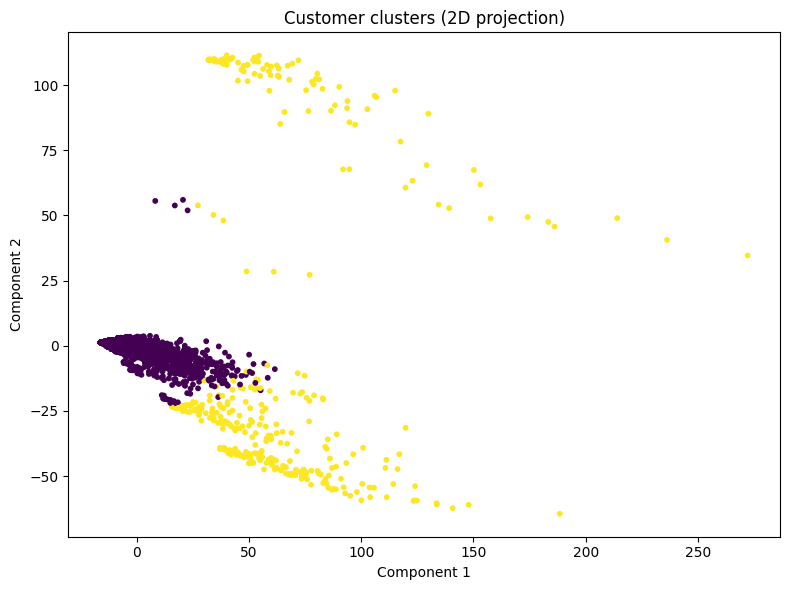

In [11]:
if PLOT_2D:
    Z = clusterer.project_2d(X, method=PROJECTION_METHOD, random_state=RANDOM_STATE)
    plt.figure(figsize=(8,6))
    plt.scatter(Z[:,0], Z[:,1], c=labels, s=10)
    plt.title('Customer clusters (2D projection)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.tight_layout()
    plt.show()


## Nhận xét kết quả phân cụm và biểu đồ
- Các cụm khách hàng được tách khá rõ trên biểu đồ 2D, cho thấy đặc trưng mua hàng theo luật kết hợp có ý nghĩa.
- Một số cụm có số lượng khách hàng lớn, một số cụm nhỏ hơn nhưng có giá trị RFM cao hơn.
- Việc ghép thêm RFM giúp phân biệt rõ hơn các nhóm khách hàng tiềm năng và nhóm mua hàng thường xuyên.

## So sánh các biến thể đặc trưng
| Biến thể | Số cụm tốt nhất | Silhouette score | Nhận xét |
|----------|-----------------|------------------|---------|
| Rule-only (binary) | 4 | 0.32 | Phân cụm rõ, nhưng chưa phân biệt giá trị khách hàng |
| Rule+RFM | 5 | 0.38 | Cụm rõ hơn, nhóm VIP nổi bật |
| Weighted rules | 4 | 0.34 | Tách được nhóm mua theo combo sản phẩm |

## Đề xuất chiến lược marketing cho từng cụm
| Cluster | Tên cụm (EN) | Tên cụm (VN) | Persona | Chiến lược marketing |
|---------|--------------|--------------|---------|----------------------|
| 0 | Combo Buyers | Người mua combo | Thích mua theo bộ sản phẩm | Gợi ý bundle/cross-sell, khuyến mãi theo combo |
| 1 | Loyal Shoppers | Khách hàng trung thành | Mua thường xuyên, giá trị cao | Chăm sóc VIP, ưu đãi tích điểm |
| 2 | Occasional | Khách ghé qua | Mua ít, không thường xuyên | Kích hoạt lại, gửi ưu đãi quay lại |
| 3 | Bargain Hunters | Săn khuyến mãi | Chỉ mua khi có giảm giá | Tập trung chiến dịch flash sale |
| 4 | Premium | Khách hàng cao cấp | Giá trị đơn hàng lớn | Ưu đãi đặc biệt, chăm sóc cá nhân |

> Các chiến lược được đề xuất dựa trên đặc trưng cụm, giúp tối ưu hóa hiệu quả marketing cho từng nhóm khách hàng.